# Task 2

In [128]:
import pandas as pd
import numpy as np
import surprise  #conda install -c conda-forge scikit-surprise
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV

In [131]:
df = pd.read_csv('./ratings_small/ratings_small.csv')
df

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [132]:
class ProbabilisticMatrixFactorization(surprise.AlgoBase):
# Randomly initializes two Matrices, Stochastic Gradient Descent to be able to optimize the best factorization for ratings.
    def __init__(self,learning_rate,num_epochs,num_factors):
       # super(surprise.AlgoBase)
        self.alpha = learning_rate #learning rate for Stochastic Gradient Descent
        self.num_epochs = num_epochs
        self.num_factors = num_factors
    def fit(self,train):
        #randomly initialize user/item factors from a Gaussian
        P = np.random.normal(0,.1,(train.n_users,self.num_factors))
        Q = np.random.normal(0,.1,(train.n_items,self.num_factors))
        #print('fit')

        for epoch in range(self.num_epochs):
            for u,i,r_ui in train.all_ratings():
                residual = r_ui - np.dot(P[u],Q[i])
                temp = P[u,:] # we want to update them at the same time, so we make a temporary variable. 
                P[u,:] +=  self.alpha * residual * Q[i]
                Q[i,:] +=  self.alpha * residual * temp 

                
        self.P = P
        self.Q = Q

        self.trainset = train
    
    
    def estimate(self,u,i):
        #returns estimated rating for user u and item i. Prerequisite: Algorithm must be fit to training set.
        #check to see if u and i are in the train set:
        #print('gahh')

        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            nanCheck = np.dot(self.P[u],self.Q[i])
            
            if np.isnan(nanCheck):
                return self.trainset.global_mean
            else:
                return np.dot(self.P[u,:],self.Q[i,:])
        else:# if its not known we'll return the general average. 
           # print('global mean')
            return self.trainset.global_mean

In [133]:
reader = surprise.Reader(rating_scale=(1,5)) 

# The columns must correspond to user id, item id and ratings (in that order).
data = surprise.Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [134]:

### PMF

algo = ProbabilisticMatrixFactorization(learning_rate=0.05,num_epochs=5,num_factors=10)

#movielens = Dataset.load_builtin('ml-100k')

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

C:\Users\ta444503\AppData\Local\Temp/ipykernel_18408/3895740208.py:19: RuntimeWarning: overflow encountered in multiply
  Q[i,:] +=  self.alpha * residual * temp
C:\Users\ta444503\AppData\Local\Temp/ipykernel_18408/3895740208.py:18: RuntimeWarning: overflow encountered in multiply
  P[u,:] +=  self.alpha * residual * Q[i]


Evaluating RMSE, MAE of algorithm ProbabilisticMatrixFactorization on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0682  1.0502  1.0466  1.0560  1.0531  1.0548  0.0074  
MAE (testset)     0.8595  0.8097  0.8043  0.8132  0.8135  0.8200  0.0200  
Fit time          3.36    3.33    3.26    3.30    3.26    3.30    0.04    
Test time         0.14    0.15    0.21    0.17    0.22    0.18    0.03    


{'test_rmse': array([1.06820712, 1.05022826, 1.04656347, 1.05597961, 1.05309133]),
 'test_mae': array([0.85949138, 0.80972101, 0.80433447, 0.81318797, 0.81349469]),
 'fit_time': (3.358855724334717,
  3.3307342529296875,
  3.2646665573120117,
  3.3015387058258057,
  3.259916305541992),
 'test_time': (0.13993000984191895,
  0.15299558639526367,
  0.21015143394470215,
  0.16515398025512695,
  0.2198941707611084)}

In [135]:
### User-Based

sim_options = {
    "name": "cosine",
    "user_based": True,  # Compute  similarities between users
}

algo = KNNWithMeans(sim_options=sim_options)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9212  0.9170  0.9300  0.9257  0.9188  0.9225  0.0047  
MAE (testset)     0.7074  0.7029  0.7106  0.7094  0.7051  0.7071  0.0028  
Fit time          0.28    0.29    0.30    0.28    0.30    0.29    0.01    
Test time         1.03    1.09    1.06    1.07    1.04    1.06    0.02    


{'test_rmse': array([0.92118184, 0.91696143, 0.93004122, 0.92565053, 0.91884941]),
 'test_mae': array([0.70744069, 0.70292402, 0.71056741, 0.70939338, 0.70506218]),
 'fit_time': (0.2774658203125,
  0.2851128578186035,
  0.2987518310546875,
  0.2817375659942627,
  0.29532599449157715),
 'test_time': (1.0335612297058105,
  1.0898876190185547,
  1.0613670349121094,
  1.072035312652588,
  1.0359272956848145)}

In [136]:
### Item-Based

sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute  similarities between items
}

algo = KNNWithMeans(sim_options=sim_options)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9236  0.9313  0.9315  0.9222  0.9215  0.9260  0.0044  
MAE (testset)     0.7082  0.7145  0.7141  0.7049  0.7079  0.7099  0.0038  
Fit time          4.03    3.95    4.08    4.05    3.89    4.00    0.07    
Test time         4.31    4.30    4.41    4.13    4.01    4.23    0.14    


{'test_rmse': array([0.92364464, 0.93125741, 0.93146839, 0.92215045, 0.92149123]),
 'test_mae': array([0.70824408, 0.71447741, 0.71408731, 0.70487712, 0.70786907]),
 'fit_time': (4.033157825469971,
  3.9522476196289062,
  4.080250263214111,
  4.0493621826171875,
  3.8931264877319336),
 'test_time': (4.3087310791015625,
  4.299349069595337,
  4.407606601715088,
  4.132535934448242,
  4.012368202209473)}

In [137]:
### User-Based

sim_options = {
    "name": "msd",
    "user_based": True,  # Compute  similarities between users
}

algo = KNNWithMeans(sim_options=sim_options)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9157  0.9159  0.9254  0.9113  0.9195  0.9176  0.0047  
MAE (testset)     0.7033  0.7025  0.7058  0.6971  0.7038  0.7025  0.0029  
Fit time          0.12    0.14    0.14    0.14    0.15    0.14    0.01    
Test time         1.02    1.05    1.08    1.12    1.00    1.05    0.04    


{'test_rmse': array([0.91567645, 0.91592417, 0.92544941, 0.91131458, 0.91954438]),
 'test_mae': array([0.70326575, 0.70247154, 0.70578526, 0.69710711, 0.70377163]),
 'fit_time': (0.12449860572814941,
  0.14060258865356445,
  0.14074039459228516,
  0.14087128639221191,
  0.15395474433898926),
 'test_time': (1.0164828300476074,
  1.0468294620513916,
  1.079228162765503,
  1.1248505115509033,
  1.0031208992004395)}

In [138]:
### Item-Based

sim_options = {
    "name": "msd",
    "user_based": False,  # Compute  similarities between items
}

algo = KNNWithMeans(sim_options=sim_options)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9022  0.9211  0.9214  0.9153  0.9205  0.9161  0.0073  
MAE (testset)     0.6916  0.7047  0.7042  0.7025  0.7035  0.7013  0.0049  
Fit time          2.10    2.13    2.10    2.17    2.09    2.12    0.03    
Test time         4.47    4.09    4.09    4.17    4.05    4.18    0.15    


{'test_rmse': array([0.90216873, 0.92107721, 0.92142955, 0.91533213, 0.92052095]),
 'test_mae': array([0.69156625, 0.70467136, 0.70422936, 0.70250027, 0.703505  ]),
 'fit_time': (2.0983643531799316,
  2.126330852508545,
  2.10198712348938,
  2.1664395332336426,
  2.093984365463257),
 'test_time': (4.470997095108032,
  4.092365264892578,
  4.092595338821411,
  4.172011852264404,
  4.0489349365234375)}

In [139]:
### User-Based

sim_options = {
    "name": "pearson",
    "user_based": True,  # Compute  similarities between users
}

algo = KNNWithMeans(sim_options=sim_options)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9241  0.9228  0.9204  0.9259  0.9271  0.9241  0.0023  
MAE (testset)     0.7030  0.7057  0.6997  0.7075  0.7061  0.7044  0.0028  
Fit time          0.30    0.33    0.35    0.34    0.34    0.33    0.02    
Test time         1.06    1.02    1.12    1.06    1.06    1.06    0.03    


{'test_rmse': array([0.92410481, 0.92282429, 0.92040423, 0.92589224, 0.92706836]),
 'test_mae': array([0.70296885, 0.70569394, 0.69972511, 0.70748399, 0.70606814]),
 'fit_time': (0.2957184314727783,
  0.33249878883361816,
  0.34504246711730957,
  0.3423316478729248,
  0.3446812629699707),
 'test_time': (1.06276273727417,
  1.0154516696929932,
  1.122213363647461,
  1.0619688034057617,
  1.0604217052459717)}

In [140]:
### Item-Based

sim_options = {
    "name": "pearson",
    "user_based": False,  # Compute  similarities between items
}

algo = KNNWithMeans(sim_options=sim_options)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9315  0.9274  0.9192  0.9338  0.9287  0.9281  0.0050  
MAE (testset)     0.7125  0.7094  0.7015  0.7112  0.7072  0.7083  0.0039  
Fit time          5.22    5.09    5.03    5.12    5.04    5.10    0.07    
Test time         4.03    4.11    4.03    4.06    4.08    4.06    0.03    


{'test_rmse': array([0.93153672, 0.92737367, 0.91924081, 0.93384243, 0.92873938]),
 'test_mae': array([0.71248083, 0.70936684, 0.70148932, 0.71115422, 0.70716541]),
 'fit_time': (5.223212718963623,
  5.094036817550659,
  5.027122735977173,
  5.1225244998931885,
  5.041370868682861),
 'test_time': (4.026978254318237,
  4.1104981899261475,
  4.031648397445679,
  4.064659357070923,
  4.0796849727630615)}

In [141]:

sim_options2 = {
    "name": ["cosine", "msd", "pearson"],
    "user_based": [True]
}

param_grid2 = {"sim_options": sim_options2, "k": [30, 35, 40, 45, 50]}

gs2 = GridSearchCV(KNNWithMeans, param_grid2, measures=["rmse"], cv=5)
gs2.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [142]:
print(gs2.best_params["rmse"])
print(gs2.best_score["rmse"])

{'sim_options': {'name': 'msd', 'user_based': True}, 'k': 40}
0.9202580242241355


In [143]:
sim_options = {
    "name": ["msd"],
    "user_based": [False],
}

param_grid = {"sim_options": sim_options, "k": [70, 80, 90, 100, 150, 200, 300]}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=5)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [144]:
print(gs.best_params["rmse"])
print(gs.best_score["rmse"])

{'sim_options': {'name': 'msd', 'user_based': False}, 'k': 150}
0.9096702454981557


In [145]:
sim_options = {
    "name": ["cosine", "msd", "pearson"],
    "user_based": [False],
}

param_grid = {"sim_options": sim_options, "k": [70, 80, 90, 100, 150, 200, 300]}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=5)
gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [146]:
print(gs.best_params["rmse"])
print(gs.best_score["rmse"])

{'sim_options': {'name': 'msd', 'user_based': False}, 'k': 200}
0.9111627941233212


In [147]:
### User-Based

sim_options = {
    "name": "msd",
    "user_based": True,  # Compute  similarities between users
}

for k in [40, 45, 50, 100, 150, 200]:
    algo = KNNWithMeans(sim_options=sim_options, k = k)
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9176  0.9206  0.9192  0.9262  0.9119  0.9191  0.0046  
Fit time          0.14    0.15    0.14    0.14    0.14    0.14    0.00    
Test time         1.02    1.07    1.06    1.04    1.08    1.05    0.02    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing simi

In [148]:
### Item-Based

sim_options = {
    "name": "msd",
    "user_based": False,  # Compute  similarities between users
}

for k in [40, 45, 50, 100, 150, 200]:
    algo = KNNWithMeans(sim_options=sim_options, k = k)
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9164  0.9131  0.9104  0.9161  0.9196  0.9151  0.0031  
Fit time          2.10    2.23    2.15    2.17    2.15    2.16    0.04    
Test time         4.34    4.44    4.41    4.25    4.20    4.33    0.09    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing simi

In [149]:
## Finding optimum neighbours
### User-Based

sim_options = {
    "name": "msd",
    "user_based": True,  # Compute  similarities between users
}

for k in [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]:
    print("k = ",k)
    algo = KNNWithMeans(sim_options=sim_options, k = k)
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
    print("\n")

k =  10
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9264  0.9320  0.9248  0.9306  0.9343  0.9296  0.0035  
Fit time          0.15    0.14    0.16    0.20    0.17    0.16    0.02    
Test time         0.87    0.78    0.84    0.81    0.92    0.85    0.05    


k =  15
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
D

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9207  0.9182  0.9140  0.9274  0.9158  0.9192  0.0047  
Fit time          0.16    0.17    0.16    0.16    0.20    0.17    0.01    
Test time         1.28    1.23    1.25    1.20    1.33    1.26    0.04    


k =  70
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 s

In [150]:
## Finding optimum neighbours
### Item-Based

sim_options = {
    "name": "msd",
    "user_based": False,  # Compute  similarities between users
}

for k in [130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200]:
    print(k)
    algo = KNNWithMeans(sim_options=sim_options, k = k)
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
    print("\n")

130
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9021  0.9152  0.9092  0.9129  0.9143  0.9107  0.0048  
Fit time          2.13    2.22    2.20    2.17    2.22    2.19    0.03    
Test time         6.44    6.20    6.39    5.95    6.47    6.29    0.19    


135
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done comp

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9208  0.9056  0.9088  0.9057  0.9050  0.9092  0.0060  
Fit time          2.12    2.20    2.17    2.12    2.13    2.15    0.03    
Test time         6.73    6.71    6.40    6.65    6.31    6.56    0.17    


190
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2 

In [151]:
## Finding optimum neighbours
### User-Based

sim_options = {
    "name": "msd",
    "user_based": True,  # Compute  similarities between users
}

for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100,
         105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200]:
    print("k = ",k)
    algo = KNNWithMeans(sim_options=sim_options, k = k)
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

k =  5
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9496  0.9597  0.9586  0.9477  0.9550  0.9541  0.0048  
Fit time          0.15    0.15    0.16    0.16    0.14    0.15    0.01    
Test time         0.68    0.80    0.70    0.75    0.73    0.73    0.04    
k =  10
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9239  0.9199  0.9183  0.9168  0.9165  0.9191  0.0027  
Fit time          0.14    0.14    0.16    0.16    0.14    0.15    0.01    
Test time         1.09    1.16    1.11    1.18    1.12    1.13    0.03    
k =  65
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 spl

Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9205  0.9250  0.9243  0.9103  0.9218  0.9204  0.0053  
Fit time          0.13    0.14    0.14    0.16    0.17    0.15    0.02    
Test time         1.23    1.17    1.27    1.29    1.38    1.27    0.07    
k =  120
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9319  0.9119  0.9174  0.9153  0.9289  0.9211  0.0079  
Fit time          0.14    0.16    0.16    0.18    0.16    0.

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9215  0.9162  0.9276  0.9216  0.9219  0.9218  0.0036  
Fit time          0.14    0.16    0.16    0.15    0.19    0.16    0.02    
Test time         1.23    1.21    1.25    1.16    1.20    1.21    0.03    
k =  180
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the m

In [152]:
## Finding optimum neighbours
### Item-Based

sim_options = {
    "name": "msd",
    "user_based": False,  # Compute  similarities between users
}

for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100,
         105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200]:
    print("k = ",k)
    algo = KNNWithMeans(sim_options=sim_options, k = k)
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
    print("\n")

k =  5
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9661  0.9774  0.9783  0.9744  0.9814  0.9755  0.0052  
Fit time          2.09    2.16    2.21    2.14    2.19    2.16    0.04    
Test time         3.17    3.34    3.34    3.18    3.32    3.27    0.08    


k =  10
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Do

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9087  0.9043  0.9168  0.9212  0.9043  0.9110  0.0068  
Fit time          2.14    2.16    2.19    2.12    2.13    2.15    0.02    
Test time         4.70    4.80    4.64    4.36    5.01    4.70    0.21    


k =  65
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 s

Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9132  0.9118  0.9160  0.9084  0.9108  0.9120  0.0025  
Fit time          2.14    2.12    2.17    2.19    2.13    2.15    0.03    
Test time         5.75    5.78    5.44    5.68    5.59    5.65    0.12    


k =  120
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9137  0.9074  0.9030  0.9079  0.9170  0.

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9093  0.9068  0.9100  0.9056  0.9092  0.9082  0.0017  
Fit time          2.12    2.17    2.11    2.09    2.10    2.12    0.03    
Test time         6.38    5.95    6.16    6.03    6.01    6.11    0.15    


k =  180
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the

Text(0.5, 1.0, 'Average RMSE')

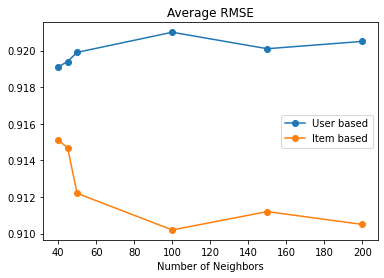

In [158]:
x = [40,45,50,100,150,200]
y = [0.9191,0.9194,0.9199,0.9210,0.9201,0.9205]
y1 = [0.9151,0.9147,0.9122,0.9102,0.9112,0.9105]

import matplotlib.pyplot as plt

plt.plot(x,y,'o-',label = 'User based')
plt.plot(x,y1,'o-', label = 'Item based')
plt.xlabel('Number of Neighbors')
plt.legend()
plt.title("Average RMSE")


Text(0.5, 1.0, 'Average RMSE')

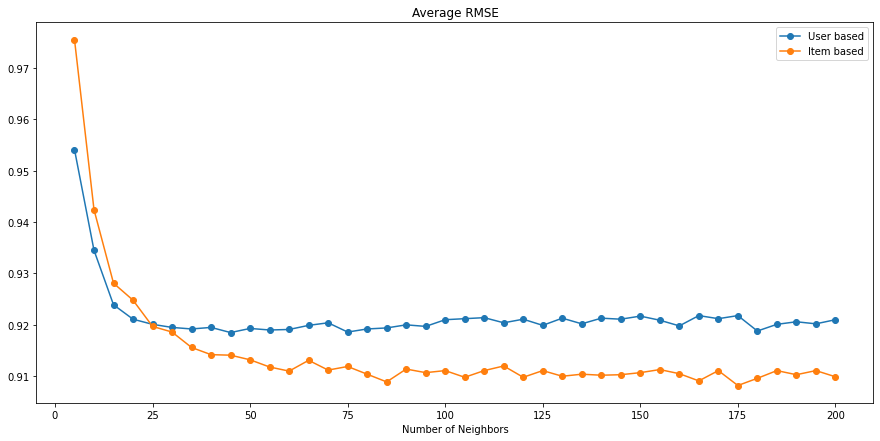

In [161]:
y = [0.9541,0.9345,0.9239,0.9211,0.9201,0.9195,0.9192,0.9195,0.9185,0.9193,0.9190,0.9191,0.9199,
     0.9204,0.9186,0.9192,0.9194,0.92,0.9197,0.9210,0.9212,0.9214,0.9204,0.9211,0.9199,0.9213,
     0.9202,0.9213,0.9211,0.9217,0.9209,0.9198,0.9218,0.9212,0.9218,0.9188,0.9201,0.9206,0.9202,
     0.9210]

x = list(range(5,205,5))

y1 = [0.9755,0.9424,0.9281,0.9248,0.9197,0.9186,0.9156,0.9142,0.9141,0.9132,0.9118,0.9110,0.9131,
      0.9112,0.9119,0.9104,0.9089,0.9114,0.9107,0.9111,0.9098,0.9111,0.9120,0.9098,0.9111,0.9100,
      0.9104,0.9102,0.9103,0.9107,0.9113,0.9105,0.9091,0.9111,0.9082,0.9096,0.9111,0.9103,0.9111,
      0.9099]

fig,ax2 = plt.subplots(figsize=(15,7))
plt.plot(x,y,'o-',label = 'User based')
plt.plot(x,y1,'o-', label = 'Item based')
plt.xlabel('Number of Neighbors')
plt.legend()
plt.title("Average RMSE")